In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl


Using TensorFlow backend.


In [ ]:
df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.remove_invalid_tracks(df)
df = data_tracks.preprocess(df)
df = data_tracks.add_outcome(df)
n = df.shape[0]

# make logistic data
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['outcome'].values


# split testing data based on cell num
idxs_test = df.cell_num.isin([6])
X_test, Y_test = X[idxs_test], y[idxs_test]

metric                   	validation
balanced_accuracy        	0.797 ~ 0.025
accuracy                 	0.881 ~ 0.018
precision                	0.777 ~ 0.083
recall                   	0.649 ~ 0.079
f1                       	0.699 ~ 0.030
roc_auc                  	0.943 ~ 0.007

feature importances
X_max                    	0.211 ~ 0.014
lifetime                 	0.582 ~ 0.018
total_displacement       	0.091 ~ 0.005
mean_square_displacement 	0.116 ~ 0.005


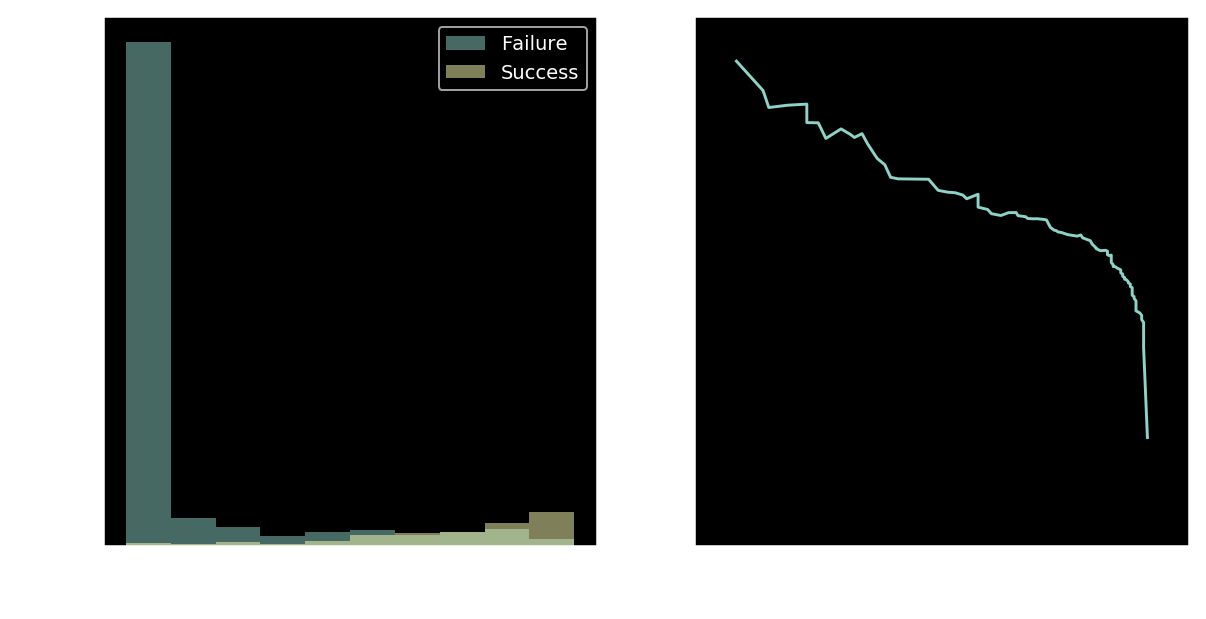

In [17]:
def visualize_individual_results(results):
    scores_cv = results['cv']
    scores_test = results['test']
    imps = results['imps']
    m = imps['model'][0]
    print(Fore.CYAN + f'{"metric":<25}\tvalidation') #\ttest')
    for s in results['metrics']:
        if not 'curve' in s:
            print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}')
    #         print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}\t{np.mean(scores_test[s]):.3f} ~ {np.std(scores_test[s]):.3f}')

    print(Fore.CYAN + '\nfeature importances')
    imp_mat = np.array(imps['imps'])
    imp_mu = imp_mat.mean(axis=0)
    imp_sd = imp_mat.std(axis=0)
    for i, feat_name in enumerate(results['feat_names']):
        print(Fore.WHITE + f'{feat_name:<25}\t{imp_mu[i]:.3f} ~ {imp_sd[i]:.3f}')

    # print(m.coef_)
    plt.figure(figsize=(10, 5), dpi=140)
    R, C = 1, 2
    plt.subplot(R, C, 1)
    preds = m.predict_proba(X_test)[:, 1]
    plt.hist(preds[Y_test==0], alpha=0.5, label='Failure')
    plt.hist(preds[Y_test==1], alpha=0.5, label='Success')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(R, C, 2)
    prec, rec, thresh = scores_test['precision_recall_curve'][0]
    plt.plot(rec, prec)
    plt.xlim((-0.1, 1.1))
    plt.ylim((-0.1, 1.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

out_dir = 'results/classify'
results = pkl.load(open(oj(out_dir, 'rf.pkl'), 'rb'))
visualize_individual_results(results)

In [100]:
def highlight_max(data, color='blue'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)



def visualize_metrics(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        metrics = {k: d['cv'][k] for k in d['cv'].keys() if not 'curve' in k}
        out = {k: np.mean(metrics[k]) for k in metrics}
        out.update({k + '_std': np.std(metrics[k]) for k in metrics})
        out['model_type'] = d['model_type']
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1).T.infer_objects()
    r = r.reindex(sorted(r.columns), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r


def visualize_feature_importances(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        imp_mat = np.array(d['imps']['imps'])
        imp_mu = imp_mat.mean(axis=0)
        imp_sd = imp_mat.std(axis=0)
        out = {feat_names[i]: imp_mu[i] for i in range(len(feat_names))}
        out.update({feat_names[i]+'_std': imp_sd[i] for i in range(len(feat_names))})
        out['model_type'] = d['model_type']
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1).T.infer_objects()
    r = r.reindex(sorted(r.columns), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r

out_dir = 'results/classify'
r = visualize_metrics(out_dir)
r.style.apply(highlight_max, subset=[k for k in r if not 'std' in k])

,accuracy,accuracy_std,balanced_accuracy,balanced_accuracy_std,f1,f1_std,precision,precision_std,recall,recall_std,roc_auc,roc_auc_std
model_type,,,,,,,,,,,,
logistic,0.879,0.015,0.794,0.034,0.725,0.047,0.908,0.065,0.615,0.091,0.955,0.005
svm,0.857,0.021,0.773,0.038,0.701,0.064,0.958,0.021,0.558,0.082,0.897,0.017
dt,0.858,0.029,0.763,0.021,0.608,0.035,0.618,0.088,0.616,0.067,0.767,0.04
rf,0.881,0.018,0.797,0.025,0.699,0.03,0.777,0.083,0.649,0.079,0.943,0.007


In [103]:
r2 = visualize_feature_importances(out_dir)
# r2.style.apply(highlight_max, subset=[k for k in r if not 'std' in k])
r2[[k for k in r2 if not 'std' in k]]

,X_max,lifetime,mean_square_displacement,total_displacement
model_type,,,,
logistic,0.585,2.619,-1.617,0.225
svm,0.000,0.166,0.011,0.000
dt,0.107,0.721,0.089,0.082
rf,0.211,0.582,0.116,0.091
